In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
from collections import defaultdict
import math


The dataset was loaded, and an initial examination of its first few rows was performed to better understand its structure and contents.

In [23]:
df = pd.read_csv("amazon_reviews.csv")

df.head()

,Title,Content,Star
0,Didn't work,No change in nails at all.,1.0
1,Worst nail product I have ever used.,Garbage! Do not waste your $$$. My nails were ...,1.0
2,Just didn't work,Nails are still brittle,1.0
3,Scum,Didn’t do any improvement at all.,1.0
4,Okay for cuticles,"Helped cuticles, didn't do much for my nails. ...",1.0


A count plot was created to visualize the distribution of star ratings.
After displaying the plot, it was observed that the number of reviews was approximately equal for each star rating.

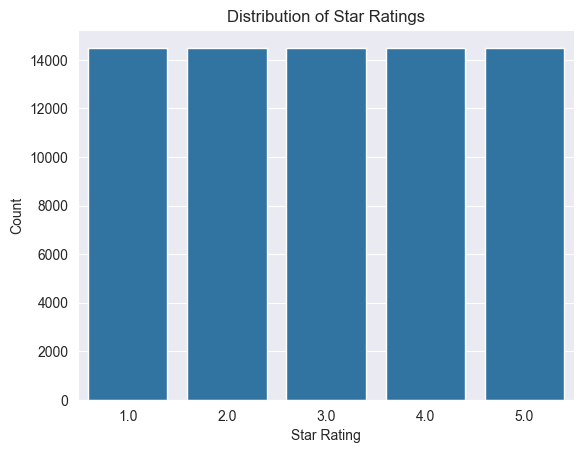

In [24]:
sns.countplot(x='Star', data=df)
plt.title("Distribution of Star Ratings")
plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.show()


The lengths of the titles and contents were calculated by counting the number of words in each.
The average lengths for both titles and contents were then computed to better understand the typical size of the reviews.
Afterward, a histogram was created to visualize the distribution of content lengths.
From the histogram, it was observed that most reviews contained a relatively small number of words, with only a few reviews being significantly longer.

In [25]:
df['title_length'] = df['Title'].astype(str).apply(lambda x: len(x.split()))
df['content_length'] = df['Content'].astype(str).apply(lambda x: len(x.split()))

min_title_length = df['title_length'].min()
max_title_length = df['title_length'].max()
print("Minimum Title Length:", min_title_length)
print("Maximum Content Length:", max_title_length)

Minimum Title Length: 1
Maximum Content Length: 25


In [26]:
print("Average Title Length:", df['title_length'].mean())
print("Average Content Length:", df['content_length'].mean())


Average Title Length: 4.170965517241379
Average Content Length: 36.46804137931034


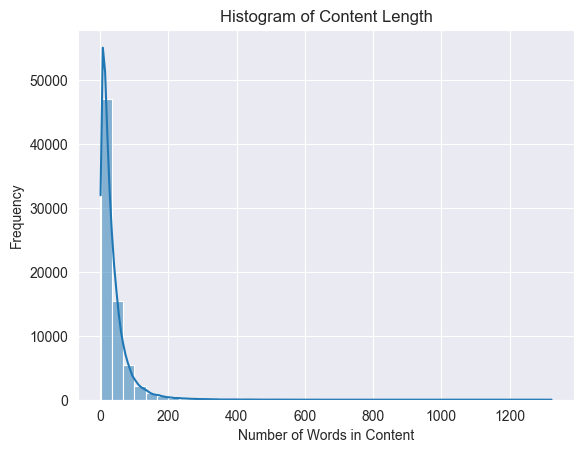

In [27]:
sns.histplot(df['content_length'], bins=40, kde=True)
plt.title("Histogram of Content Length")
plt.xlabel("Number of Words in Content")
plt.ylabel("Frequency")
plt.show()


The text from all reviews was combined into a single string to create a unified body of text.
A word cloud was then generated to visually represent the most frequently used words in the review content.
After displaying the word cloud, it was observed that words such as "use," "one," and "product" appeared most prominently, indicating their frequent usage among the reviews.

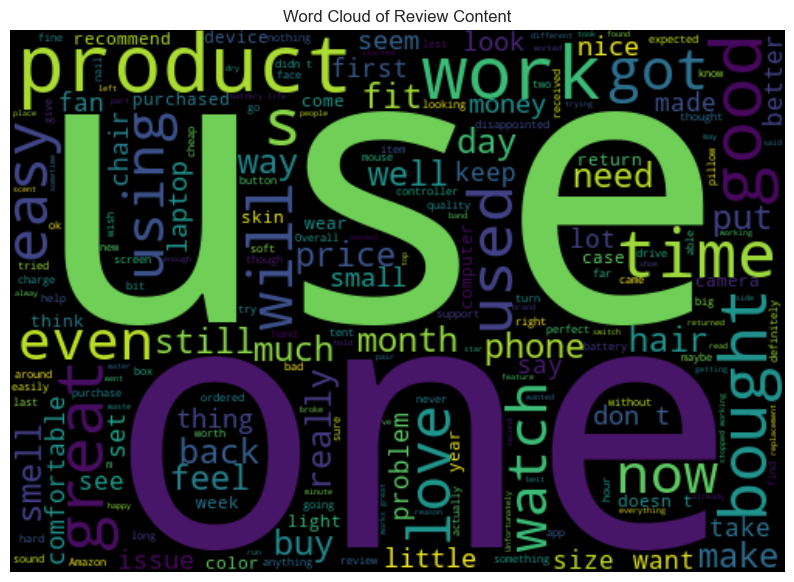

In [28]:
text = " ".join(review for review in df['Content'].astype(str))
wordcloud = WordCloud(width=500, height=350).generate(text)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Review Content")
plt.show()


The text in the title and content fields was cleaned by converting all characters to lowercase and removing unwanted symbols, while preserving basic punctuation marks for future analysis.
After the cleaning process, the title and content of each review were combined into a single text field to facilitate further processing

In [29]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s.,!?]', '', text)  # keep . , ! ? for n-gram purposes
    return text

df['Title'] = df['Title'].astype(str).apply(clean_text)
df['Content'] = df['Content'].astype(str).apply(clean_text)
df['Combined'] = df['Title'] + " " + df['Content']


A tokenization function was defined to split the text into individual words or into sequences of two or three consecutive words, depending on the specified value of n.
This allowed the text to be prepared for further analysis using unigrams, bigrams, or trigrams.

In [30]:
def tokenize(text, n=1):
    words = text.split()
    if n == 1:
        return words
    elif n == 2:
        return [f"{words[i]} {words[i+1]}" for i in range(len(words)-1)]
    elif n == 3:
        return [f"{words[i]} {words[i+1]} {words[i+2]}" for i in range(len(words)-2)]


A sample text from the combined reviews was selected and tokenized into unigrams, bigrams, and trigrams.
Through this process, the structure and behavior of the tokenization function were verified.

In [31]:
sample = df['Combined'].iloc[0]
print("Unigrams:", tokenize(sample, 1))
print("Bigrams:", tokenize(sample, 2))
print("Trigrams:", tokenize(sample, 3))


Unigrams: ['didnt', 'work', 'no', 'change', 'in', 'nails', 'at', 'all.']
Bigrams: ['didnt work', 'work no', 'no change', 'change in', 'in nails', 'nails at', 'at all.']
Trigrams: ['didnt work no', 'work no change', 'no change in', 'change in nails', 'in nails at', 'nails at all.']


A function was implemented to calculate the frequency of tokens within a collection of texts.
Depending on the specified n-gram level, unigrams, bigrams, or a combination of both were extracted.
Stopwords were removed to focus on more meaningful terms, and the frequency of each token was counted and stored.
This process enabled the identification of the most commonly occurring terms or phrases in the dataset.

In [32]:
def get_token_frequencies(texts, n_gram):
    freq = defaultdict(int)

    for text in texts:
        if n_gram == 1:
            tokens = remove_stopwords(tokenize(text, 1))
        elif n_gram == 2:
            tokens = remove_stopwords_from_bigrams(tokenize(text, 2))
        elif n_gram == "combined":
            tokens = remove_stopwords(tokenize(text, 1)) + remove_stopwords_from_bigrams(tokenize(text, 2))
        else:
            tokens = tokenize(text, n_gram)

        for token in tokens:
            freq[token] += 1

    return freq


A predefined list of stopwords was used to filter out commonly occurring but less meaningful words from the text.
Functions were defined to remove stopwords from unigrams, bigrams, and trigrams, ensuring that only significant tokens were retained.
These functions were then applied to the combined review texts to generate cleaned versions of unigrams, bigrams, and trigrams for each entry.
To verify the effectiveness of stopword removal, sample outputs before and after the cleaning process were displayed.



In [33]:
stopwords = {"i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "now"}


def remove_stopwords(tokens):
    return [token for token in tokens if token not in stopwords]

df['clean_tokens'] = df['Combined'].apply(lambda x: remove_stopwords(tokenize(x, 1)))



def remove_stopwords_from_bigrams(bigrams):
    return [bigram for bigram in bigrams
            if all(word not in stopwords for word in bigram.split())]

df['clean_bigrams'] = df['Combined'].apply(lambda x: remove_stopwords_from_bigrams(tokenize(x, 2)))



def remove_stopwords_from_trigrams(trigrams):
    return [trigram for trigram in trigrams
            if all(word not in stopwords for word in trigram.split())]

df['clean_trigrams'] = df['Combined'].apply(lambda x: remove_stopwords_from_trigrams(tokenize(x, 3)))




print("Unigram Before:", tokenize(df['Combined'].iloc[0], 1))
print("Unigram After :", remove_stopwords(tokenize(df['Combined'].iloc[0], 1)))


print("Bigram Before:", tokenize(df['Combined'].iloc[0], 2))
print("Bigram After :", remove_stopwords_from_bigrams(tokenize(df['Combined'].iloc[0], 2)))


print("Trigram Before:", tokenize(df['Combined'].iloc[0], 3))
print("Trigram After :", remove_stopwords_from_trigrams(tokenize(df['Combined'].iloc[0], 3)))


Unigram Before: ['didnt', 'work', 'no', 'change', 'in', 'nails', 'at', 'all.']
Unigram After : ['didnt', 'work', 'no', 'change', 'nails', 'all.']
Bigram Before: ['didnt work', 'work no', 'no change', 'change in', 'in nails', 'nails at', 'at all.']
Bigram After : ['didnt work', 'work no', 'no change']
Trigram Before: ['didnt work no', 'work no change', 'no change in', 'change in nails', 'in nails at', 'nails at all.']
Trigram After : ['didnt work no', 'work no change']


A sentiment label was assigned to each review based on its star rating.
Reviews with 1 or 2 stars were labeled as negative, while those with 4 or 5 stars were labeled as positive.
Neutral reviews with 3 stars were excluded from the dataset to maintain a clear distinction between positive and negative sentiments.
As a result, rows without a sentiment label were removed from the data.

In [34]:
def label_sentiment(star):
    if star in [1, 2]:
        return 0  # Negative
    elif star in [4, 5]:
        return 1  # Positive
    else:
        return None  # Neutral or ignored

df['Label'] = df['Star'].apply(label_sentiment)
df = df.dropna(subset=['Label'])  # Drop rows with 3-star or missing labels


The title and content fields were re-concatenated and stored in the combined text column to ensure that the most up-to-date, cleaned versions of both fields were reflected in the analysis.

In [35]:
df.loc[:, 'Combined'] = df['Title'].astype(str) + " " + df['Content'].astype(str)

The dataset was divided into training and testing subsets using an 80-20 split.
Stratified sampling was applied to ensure that the distribution of sentiment labels remained consistent across both subsets.
A fixed random state was used to maintain reproducibility of the split.

In [36]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['Label']
)

Token frequencies were calculated from the training dataset using both unigrams and bigrams.
A minimum frequency threshold was applied to filter out infrequent tokens.
Tokens that appeared at least twice were retained and stored in a set to form the vocabulary of known tokens for further processing.

In [37]:
# Count token frequencies on training data
min_freq = 2  # You can adjust if needed
token_freq = get_token_frequencies(train_df['Combined'], n_gram="combined")

# Build set of known tokens
known_tokens = set(token for token, count in token_freq.items() if count >= min_freq)


Separate frequency dictionaries were constructed for unigrams, bigrams, and trigrams using the training data.
Stopwords were removed from unigrams and bigrams to focus on meaningful terms, while trigrams were processed without stopword removal to preserve phrase structure.
Each token's frequency was counted and stored in a dictionary.
The most common tokens in each n-gram category were then displayed to observe the dominant patterns in the text.

In [38]:
def build_unigram_dict(texts):
    unigram_freq = defaultdict(int)
    for text in texts:
        tokens = remove_stopwords(tokenize(text, 1))  # tokenized + cleaned
        for token in tokens:
            unigram_freq[token] += 1
    return dict(unigram_freq)

unigram_dict = build_unigram_dict(train_df['Combined'])


def build_bigram_dict(texts):
    bigram_freq = defaultdict(int)
    for text in texts:
        bigrams = remove_stopwords_from_bigrams(tokenize(text, 2))
        for bigram in bigrams:
            bigram_freq[bigram] += 1
    return dict(bigram_freq)

bigram_dict = build_bigram_dict(train_df['Combined'])



def build_trigram_dict(texts):
    trigram_freq = defaultdict(int)
    for text in texts:
        trigrams = tokenize(text, 3)  # no stopword removal for now (optional)
        for trigram in trigrams:
            trigram_freq[trigram] += 1
    return dict(trigram_freq)

trigram_dict = build_trigram_dict(train_df['Combined'])



print("Top 10 Unigrams:")
print(Counter(unigram_dict).most_common(10))

print("\nTop 10 Bigrams:")
print(Counter(bigram_dict).most_common(10))

print("\nTop 10 Trigrams:")
print(Counter(trigram_dict).most_common(10))


Top 10 Unigrams:
[('not', 23432), ('great', 9826), ('good', 9592), ('like', 7911), ('one', 6758), ('use', 6000), ('would', 5955), ('product', 5754), ('no', 5720), ('dont', 5474)]

Top 10 Bigrams:
[('would not', 993), ('not worth', 792), ('stopped working', 768), ('battery life', 686), ('not work', 664), ('not sure', 618), ('works great', 587), ('im not', 583), ('doesnt work', 577), ('great product', 574)]

Top 10 Trigrams:
[('i bought this', 778), ('for the price', 757), ('this is a', 736), ('i had to', 628), ('a lot of', 628), ('out of the', 583), ('easy to use', 569), ('one of the', 559), ('i have to', 549), ('it is a', 449)]


A custom NaiveBayesClassifier was developed to perform sentiment classification based on various n-gram representations. The model was designed to support unigram, bigram, trigram, and combined n-gram configurations. During training, tokens were extracted from the input texts, filtered using a list of known tokens (when provided), and their frequencies were updated per class using weighted counts. The weights were adjusted based on the associated star ratings to reflect varying confidence levels in sentiment (e.g., 1-star and 5-star reviews were given higher weights).

During prediction, separate token sets were created for the title and content. The probabilities of each class were computed using log-likelihoods, with weighted contributions from the title and content tokens. Laplace smoothing was applied to handle unseen tokens. The class with the highest log-probability was selected as the final prediction.

The classifier was trained separately for unigram, bigram, trigram, and combined n-gram modes using the training set. Each model was then used to predict the sentiment of reviews in the test set, and the predictions were stored in new columns for evaluation.

In [ ]:
class NaiveBayesClassifier:
    def __init__(self, n_gram=1):
        self.n_gram = n_gram
        self.class_token_counts = defaultdict(lambda: defaultdict(int))
        self.class_total_tokens = defaultdict(int)
        self.class_doc_counts = defaultdict(int)
        self.vocabulary = set()
        self.num_docs = 0
        self.known_tokens = None  # Will set it externally before training



    def train(self, texts, labels, stars):
        for text, label, star in zip(texts, labels, stars):
            self.class_doc_counts[label] += 1
            self.num_docs += 1

            # Determine weighting factor
            weight = 1.0
            if label == 0:  # Negative
                weight = 1.0 if star == 1 else 0.5
            elif label == 1:  # Positive
                weight = 1.0 if star == 5 else 0.5

            # Tokenization
            if self.n_gram == 1:
                tokens = remove_stopwords(tokenize(text, 1))
            elif self.n_gram == 2:
                tokens = remove_stopwords_from_bigrams(tokenize(text, 2))
            elif self.n_gram == 3:
                tokens = remove_stopwords_from_trigrams(tokenize(text, 3))
            elif self.n_gram == "combined":
                uni = remove_stopwords(tokenize(text, 1))
                bi = remove_stopwords_from_bigrams(tokenize(text, 2))
                tri = remove_stopwords_from_trigrams(tokenize(text, 3))
                tokens = uni + bi + tri
            else:
                tokens = tokenize(text, self.n_gram)

            for token in tokens:
                 if self.known_tokens is not None:
                        token = token if token in self.known_tokens else "<UNK>"
                 self.vocabulary.add(token)
                 self.class_token_counts[label][token] += weight
                 self.class_total_tokens[label] += weight

    def predict_with_weights(self, title, content, title_weight=0.3, content_weight=0.7):
        if self.n_gram == 1:
            title_tokens = remove_stopwords(tokenize(title, 1))
            content_tokens = remove_stopwords(tokenize(content, 1))
        elif self.n_gram == 2:
            title_tokens = remove_stopwords_from_bigrams(tokenize(title, 2))
            content_tokens = remove_stopwords_from_bigrams(tokenize(content, 2))
        elif self.n_gram == 3:
            title_tokens = remove_stopwords_from_trigrams(tokenize(title, 3))
            content_tokens = remove_stopwords_from_trigrams(tokenize(content, 3))
        elif self.n_gram == "combined":
            title_tokens = (
                remove_stopwords(tokenize(title, 1)) +
                remove_stopwords_from_bigrams(tokenize(title, 2))
            )
            content_tokens = (
            remove_stopwords(tokenize(content, 1)) +
            remove_stopwords_from_bigrams(tokenize(content, 2)) +
            remove_stopwords_from_trigrams(tokenize(content, 3))
            )
        else:
            title_tokens = tokenize(title, self.n_gram)
            content_tokens = tokenize(content, self.n_gram)

        class_scores = {}

        for c in self.class_doc_counts:
            # Prior: log P(C)
            log_prob = math.log(self.class_doc_counts[c] / self.num_docs)
            total_tokens = self.class_total_tokens[c]
            vocab_size = len(self.vocabulary)

            # Weighted title contribution
            for token in title_tokens:
                token = token if token in self.vocabulary else "<UNK>"
                token_count = self.class_token_counts[c].get(token, 0)
                prob = (token_count + 1) / (total_tokens + vocab_size)
                log_prob += title_weight * math.log(prob)

            # Weighted content contribution
            for token in content_tokens:
                token = token if token in self.vocabulary else "<UNK>"
                token_count = self.class_token_counts[c].get(token, 0)
                prob = (token_count + 1) / (total_tokens + vocab_size)
                log_prob += content_weight * math.log(prob)

            class_scores[c] = log_prob

        return max(class_scores, key=class_scores.get)


# Pass known_tokens
nb_comb = NaiveBayesClassifier(n_gram="combined")
nb_comb.known_tokens = known_tokens
nb_comb.train(train_df['Combined'], train_df['Label'], train_df['Star'])



#Training
nb_unigram = NaiveBayesClassifier(n_gram=1)
nb_bigram = NaiveBayesClassifier(n_gram=2)
nb_trigram = NaiveBayesClassifier(n_gram=3)

nb_unigram.train(train_df['Combined'], train_df['Label'], train_df['Star'])
nb_bigram.train(train_df['Combined'], train_df['Label'], train_df['Star'])
nb_trigram.train(train_df['Combined'], train_df['Label'], train_df['Star'])


# UNIGRAM predictions
test_df['pred_uni'] = test_df.apply(
    lambda row: nb_unigram.predict_with_weights(row['Title'], row['Content'], 0.6, 0.4),
    axis=1
)

# BIGRAM predictions
test_df['pred_bi'] = test_df.apply(
    lambda row: nb_bigram.predict_with_weights(row['Title'], row['Content'], 0.6, 0.4),
    axis=1
)

test_df['pred_tri'] = test_df.apply(
    lambda row: nb_trigram.predict_with_weights(row['Title'], row['Content'], 0.6, 0.4),
    axis=1
)

# COMBINED (unigram + bigram + trigram) predictions
nb_comb = NaiveBayesClassifier(n_gram="combined")
nb_comb.train(train_df['Combined'], train_df['Label'], train_df['Star'])

test_df['pred_comb'] = test_df.apply(
    lambda row: nb_comb.predict_with_weights(row['Title'], row['Content'], 0.6, 0.4),
    axis=1
)


Predictions generated by each Naive Bayes model were evaluated using a custom compute_metrics function. For each prediction, true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN) were counted. Based on these counts, the following metrics were computed:

Accuracy: The ratio of correctly predicted instances over all predictions.

Precision: The ratio of correctly predicted positive instances over all predicted positives.

Recall: The ratio of correctly predicted positive instances over all actual positives.

F1-score: The harmonic mean of precision and recall.

Metrics were calculated for each model individually and then assembled into a comparison table. This table was formatted to display the key performance indicators for each model in a concise and interpretable format.

In [ ]:
def compute_metrics(y_true, y_pred):
    TP = FP = TN = FN = 0

    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            TP += 1
        elif true == 0 and pred == 1:
            FP += 1
        elif true == 0 and pred == 0:
            TN += 1
        elif true == 1 and pred == 0:
            FN += 1

    accuracy = (TP + TN) / (TP + TN + FP + FN) if TP + TN + FP + FN > 0 else 0
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 / (1/precision + 1/recall) if precision + recall > 0 else 0

    return {
        "TP": TP, "TN": TN, "FP": FP, "FN": FN,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }



# Compute metrics separately for each model
metrics_uni = compute_metrics(test_df['Label'].tolist(), test_df['pred_uni'].tolist())
metrics_bi = compute_metrics(test_df['Label'].tolist(), test_df['pred_bi'].tolist())
metrics_tri = compute_metrics(test_df['Label'].tolist(), test_df['pred_tri'].tolist())
metrics_comb = compute_metrics(test_df['Label'].tolist(), test_df['pred_comb'].tolist())

# Create a clean comparison table
results_df = pd.DataFrame([
    {"Model": "Unigram", **metrics_uni},
    {"Model": "Bigram", **metrics_bi},
    {"Model": "Trigram", **metrics_tri},
    {"Model": "Combined", **metrics_comb}
])

# Show comparison
results_df = results_df[["Model", "accuracy", "precision", "recall", "f1_score"]]
results_df





The predictions generated by each Naive Bayes model were assessed using a custom compute_metrics function. This function was used to calculate key performance metrics based on the counts of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN). The following metrics were then derived:

Accuracy: The proportion of correctly predicted instances out of all predictions.

Precision: The ratio of correctly predicted positive instances to the total predicted positives.

Recall: The ratio of correctly predicted positive instances to the total actual positives.

F1-score: The harmonic mean of precision and recall, providing a balance between the two metrics.

The metrics were computed individually for each Naive Bayes model (unigram, bigram, trigram, and combined) and were organized into a comparison table. This table was structured to present each model's key performance indicators in a clear and easy-to-understand format. The comparison of the models allowed for an evaluation of their relative strengths and weaknesses in terms of prediction accuracy and reliability.

In [ ]:
def manual_confusion_matrix(y_true, y_pred):
    TP = FP = TN = FN = 0

    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            TP += 1
        elif true == 0 and pred == 1:
            FP += 1
        elif true == 0 and pred == 0:
            TN += 1
        elif true == 1 and pred == 0:
            FN += 1

    return [[TN, FP],
            [FN, TP]]


# Unigram Confusion Matrix
cm_uni = manual_confusion_matrix(test_df['Label'].tolist(), test_df['pred_uni'].tolist())
print(" Unigram Confusion Matrix:")
print("[TN FP]")
print(cm_uni[0])
print("[FN TP]")
print(cm_uni[1])


# Bigram Confusion Matrix
cm_bi = manual_confusion_matrix(test_df['Label'].tolist(), test_df['pred_bi'].tolist())
print("\n Bigram Confusion Matrix:")
print("[TN FP]")
print(cm_bi[0])
print("[FN TP]")
print(cm_bi[1])


# Bigram Confusion Matrix
cm_tri = manual_confusion_matrix(test_df['Label'].tolist(), test_df['pred_tri'].tolist())
print("\n Trigram Confusion Matrix:")
print("[TN FP]")
print(cm_tri[0])
print("[FN TP]")
print(cm_tri[1])



# Combined Confusion Matrix
cm_comb = manual_confusion_matrix(test_df['Label'].tolist(), test_df['pred_comb'].tolist())
print("\n Combined Confusion Matrix:")
print("[TN FP]")
print(cm_comb[0])
print("[FN TP]")
print(cm_comb[1])

